In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 3b - Coupled 2-box with vertical diffusion, only the atmospheric box is visible

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [2]:
# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 0.3         # Noise strength

# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 1

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}

# Iterate over set of experiments
for i, exp in enumerate(experiments):
  full_outputs_ensemble[exp], forcings_ensemble[exp], T_out_ensemble[exp] = [], [] ,[]

  # Run deterministic experiments once
  full_outputs_single[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i, vert_diff_flag=1)
  forcings_single[exp] = full_outputs_single[exp]['forcing_ts'] # Don't tile the forcing like the other experiments
  T_out_single[exp] = np.squeeze(full_outputs_single[exp]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[exp].append(BudykoSellers.Run_Budyko_Sellers(exp_flag=i, vert_diff_flag=1, xi=xi))
    forcings_ensemble[exp].append(full_outputs_ensemble[exp][-1]['forcing_ts']) # Don't tile the forcing like the other experiments
    T_out_ensemble[exp].append(np.squeeze(full_outputs_ensemble[exp][-1]['T_ts'])[0:n_boxes,:])

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method X: DMD

In [4]:
n_choices = 10
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1

operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_experiments('DMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
operator_ensemble_DMD, operator_L2_avg_DMD, w_pred_L2_DMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'DMD', operator_DMD, w0=w0, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 4.664026245655796
	Test: High Emissions - 0.5477700949835992
	Test: Overshoot - 3.007417788195614
Train: High Emissions - L2 Error
	Test: 2xCO2 - 6.0266710154522976
	Test: High Emissions - 0.04621546441442688
	Test: Overshoot - 1.0221105611373846
Train: Overshoot - L2 Error
	Test: 2xCO2 - 6.71263112220015
	Test: High Emissions - 1.3962063693528752
	Test: Overshoot - 0.5661293134947561


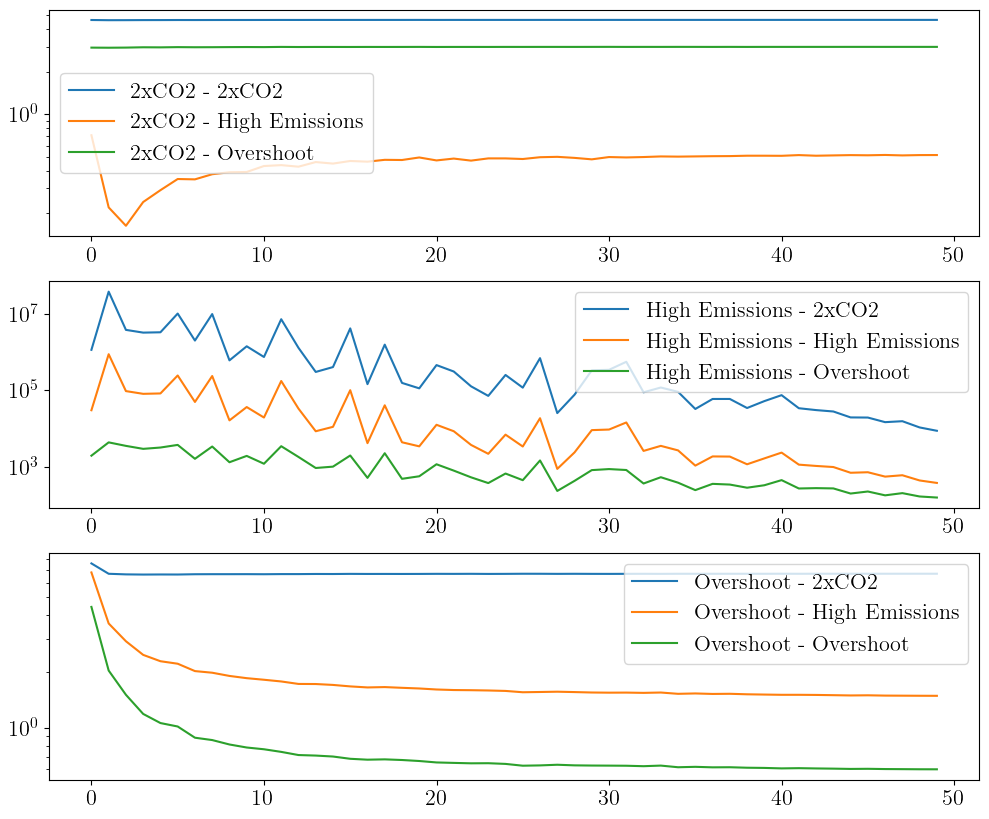

In [5]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_DMD[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: EDMD

In [6]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_experiments('EDMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
#emulator_utils.plot_true_pred(T_out_single, T_pred_EDMD, experiments)
operator_ensemble_EDMD, operator_L2_avg_EDMD, w_pred_L2_EDMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'EDMD', operator_EDMD, w_dict=w_dict, F_dict=F_dict, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 1.5956350510499937
	Test: High Emissions - 13.290759956634943
	Test: Overshoot - 4.490827408772554
Train: High Emissions - L2 Error
	Test: 2xCO2 - 6667.098720395882
	Test: High Emissions - 0.16369196902244518
	Test: Overshoot - 214.25864581980338
Train: Overshoot - L2 Error
	Test: 2xCO2 - 7.274483159705562
	Test: High Emissions - 3.1148444398809487
	Test: Overshoot - 0.10218952858522555


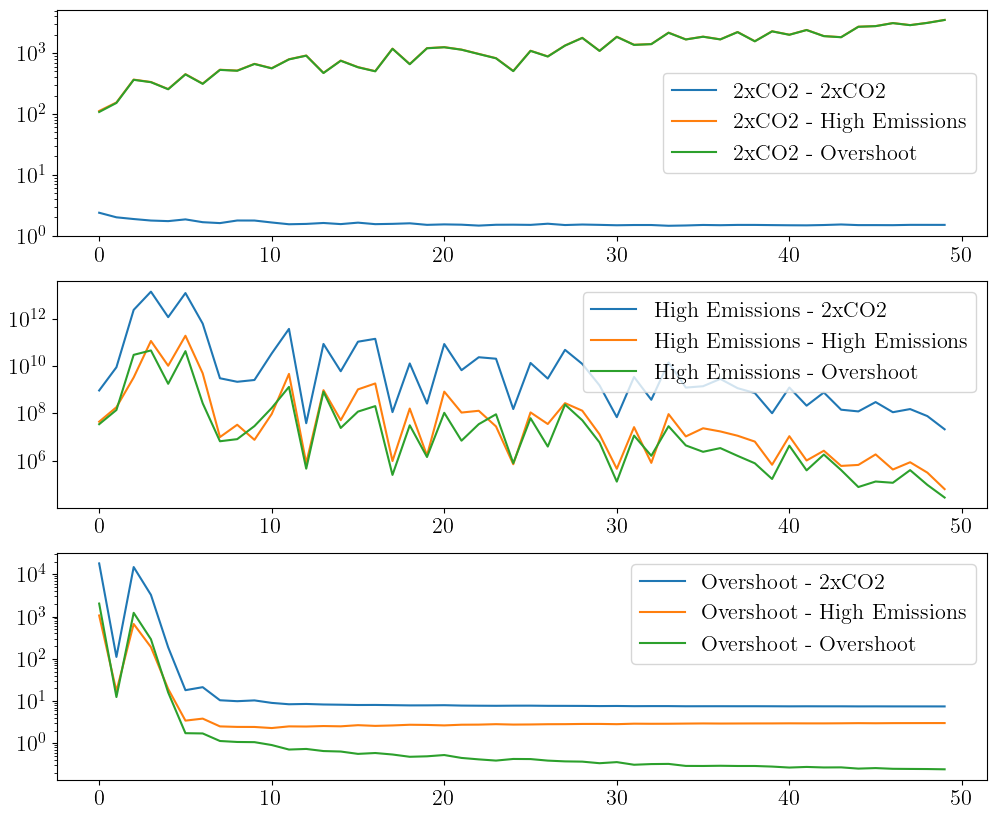

In [7]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_EDMD[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: Deconvolution

In [8]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_experiments('deconvolve', experiments=experiments, outputs=T_out_single, forcings=forcings_single, dt=dt)
#emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)
operator_ensemble_deconvolve, operator_L2_avg_deconvolve, w_pred_L2_deconvolve = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'deconvolve', operator_deconvolve, dt=dt)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 1.989128258827349e-15
	Test: High Emissions - 0.2928878699910259
	Test: Overshoot - 0.17333461851892354
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.5106908193274673
	Test: High Emissions - 2.1375748101554808e-14
	Test: Overshoot - 0.2746753160493911
Train: Overshoot - L2 Error
	Test: 2xCO2 - 388493.0378457928
	Test: High Emissions - 6246.958665308086
	Test: Overshoot - 2.441345036295938e-14


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


### Method X: Direct Diagnosis (FDT)

100%|██████████| 365239/365239 [00:05<00:00, 65683.87it/s]


Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 0.005721946699657816
	Test: High Emissions - 0.29156708842407075
	Test: Overshoot - 0.17197560723948419


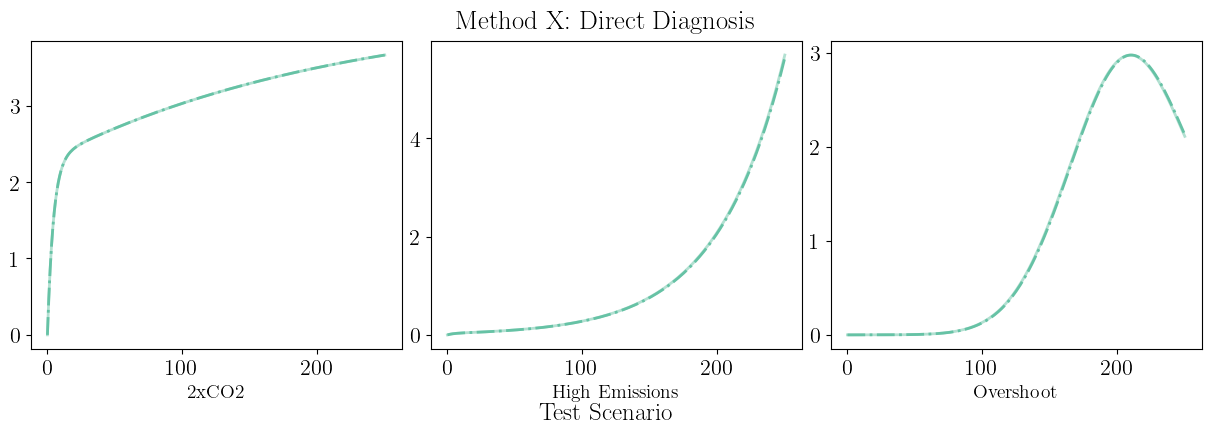

In [12]:
operator_direct, T_pred_direct = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'direct', w0, t, dt, n_steps, n_boxes, vert_diff_flag=1)
emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [ 0.0806371   0.3268406  -0.15193303 -1.0668867 ]
	Test: 2xCO2 - 6.237018830192568
	Test: High Emissions - 4.981841416845509
	Test: Overshoot - 3.7489569550790476
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.0579625   0.77528708 -0.01134497 -1.08132455]
	Test: 2xCO2 - 1.9489921479976178
	Test: High Emissions - 0.02860961445420902
	Test: Overshoot - 0.38659111279048636
Train: Overshoot - L2 Error
Exponential Fit Results:
 [ 0.03678319  0.37572334 -0.02478534 -1.12833887]
	Test: 2xCO2 - 4.011996541111644
	Test: High Emissions - 0.10108561203209186
	Test: Overshoot - 0.052238947446259516


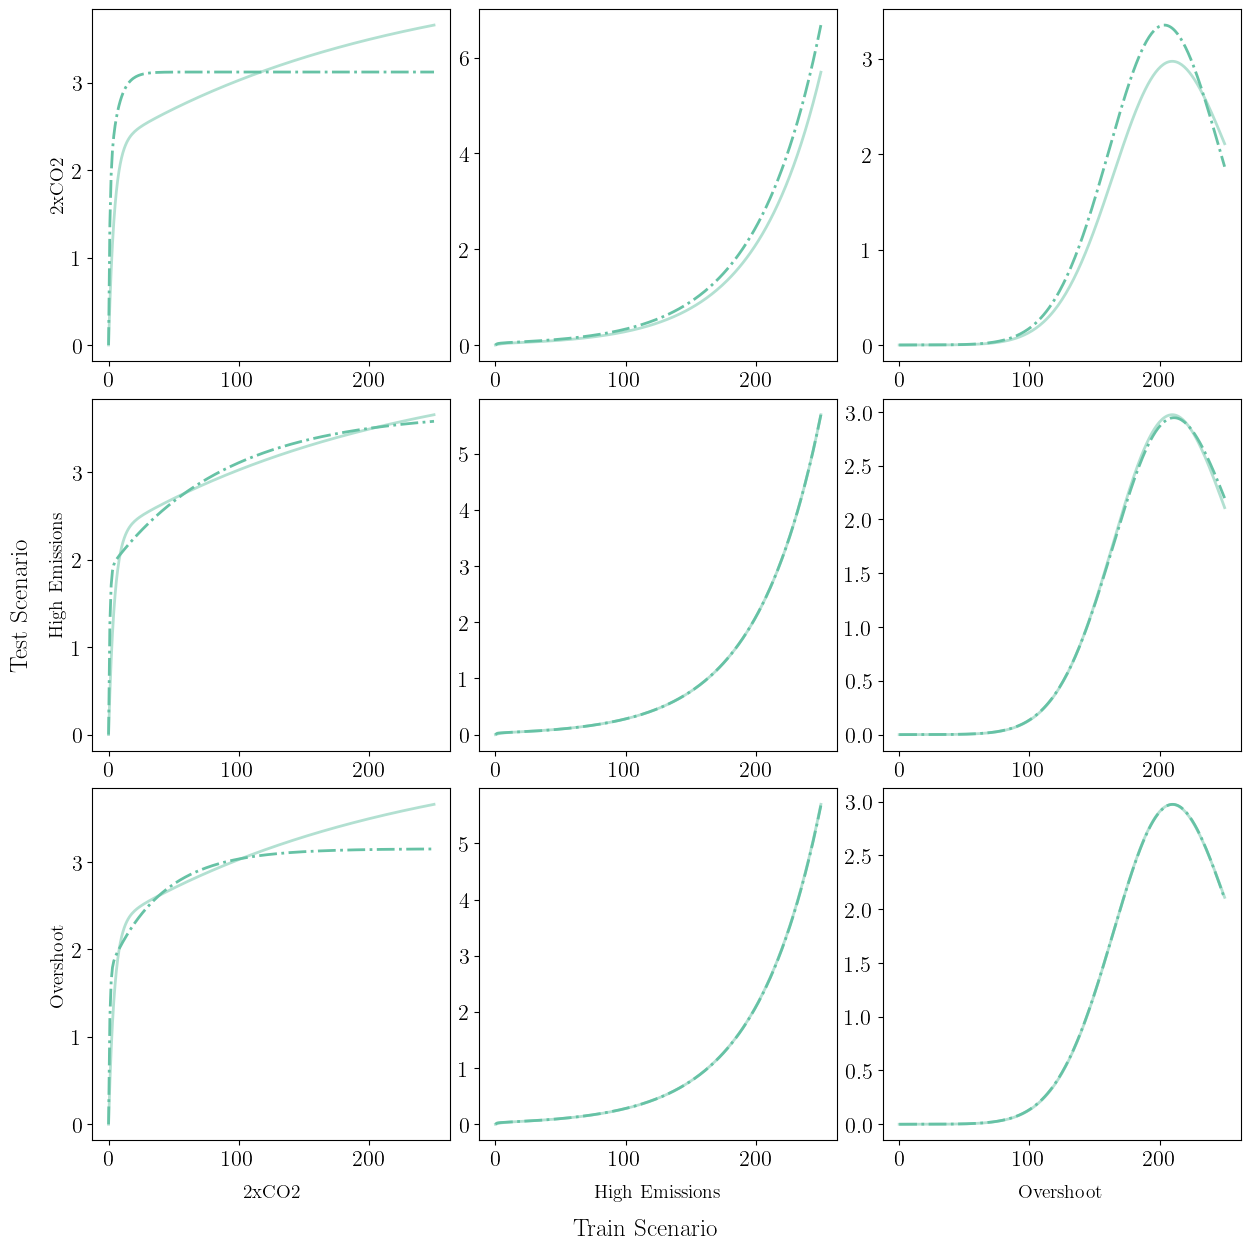

In [17]:
B=np.array([1.0])
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2, B=B)
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)